<a href="https://colab.research.google.com/github/pam-lab/JupyterFiles/blob/main/NLP_HW5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

In [2]:
!pip install -Uqq transformers
!pip install -Uqq hazm
!pip install -Uqq datasets
!pip install -Uqq seqeval

     |████████████████████████████████| 4.7 MB 8.5 MB/s 
     |████████████████████████████████| 101 kB 6.8 MB/s 
     |████████████████████████████████| 6.6 MB 43.7 MB/s 
     |████████████████████████████████| 596 kB 36.4 MB/s 
     |████████████████████████████████| 316 kB 9.6 MB/s 
     |████████████████████████████████| 1.4 MB 45.1 MB/s 
     |████████████████████████████████| 233 kB 39.2 MB/s 
     |████████████████████████████████| 365 kB 7.0 MB/s 
     |████████████████████████████████| 141 kB 53.0 MB/s 
     |████████████████████████████████| 212 kB 44.8 MB/s 
     |████████████████████████████████| 127 kB 41.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 43 kB 1.4 MB/s 


In [3]:
import numpy as np
import pandas as pd

import hazm

import transformers 
from transformers import AutoTokenizer, AutoConfig
from transformers import TFAutoModelForTokenClassification
import itertools
from datasets import Dataset
from datasets import load_metric
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification


import os
import itertools
import pandas as pd
import numpy as np
from datasets import Dataset
from datasets import load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import torch

import os
from IPython.display import display, HTML, clear_output
from ipywidgets import widgets, Layout

print()
print('tensorflow', tf.__version__)
print('transformers', transformers.__version__)
print('numpy', np.__version__)
print('pandas', pd.__version__)
print()

if tf.test.gpu_device_name() != '/device:GPU:0':
    print()
    print('WARNING: GPU device not found.')
else:
    print()
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))


tensorflow 2.8.2
transformers 4.21.0
numpy 1.21.6
pandas 1.3.5




### Fine-tune model with our data

In [4]:
!gdown 1oJjoGK15-RD7IHm8-k0DhSXFlWDaq201
!gdown 1AzXg9YVaXCAzalr57IpP1sNbWBBbZrqI
!gdown 1LXZrlNFr8jKhVF5ETEu6OwnuwPfrIyLw

Downloading...
From: https://drive.google.com/uc?id=1oJjoGK15-RD7IHm8-k0DhSXFlWDaq201
To: /content/ner-train.csv
100% 6.85M/6.85M [00:00<00:00, 37.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AzXg9YVaXCAzalr57IpP1sNbWBBbZrqI
To: /content/ner-test.csv
100% 383k/383k [00:00<00:00, 52.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LXZrlNFr8jKhVF5ETEu6OwnuwPfrIyLw
To: /content/ner-eval.csv
100% 348k/348k [00:00<00:00, 65.2MB/s]


In [5]:
data_train = pd.read_csv('ner-train.csv')
data_val = pd.read_csv('ner-eval.csv')
data_test = pd.read_csv('ner-test.csv')

In [6]:
len(data_train), len(data_val), len(data_test)

(4050, 225, 225)

In [7]:
def clean_alt_list(list_):
    list_ = list_.replace('[','').replace(']','').split(',')
    return [item.replace("'","").strip() for item in list_]

In [8]:
def convert_to_list(data):
    data['token'] = data['token'].apply(clean_alt_list)
    data['labels'] = data['labels'].apply(clean_alt_list)

In [9]:
convert_to_list(data_train)
convert_to_list(data_val)
convert_to_list(data_test)

In [10]:
data_train

,token,labels
0,"[«صندلی, داغ», و, «شب, آرام», در, نوروزی, های,...","[o, o, o, o, o, o, B-DAT, I-DAT, o, o]"
1,"[به, گزارش, خبرگزاری, مهر, به, نقل, از, روابط,...","[o, o, B-ORG, I-ORG, I-ORG, o, o, B-ORG, I-ORG..."
2,"[به, گزارش, خبرگزاری, مهر, به, نقل, از, روابط,...","[o, o, B-ORG, I-ORG, I-ORG, o, o, B-ORG, I-ORG..."
3,"[نشان, درجه, یک, هنری, استاد, «محمدرضا, اسحاقی...","[o, o, o, o, o, o, B-PER, o, o, o, o, o, o, o, o]"
4,"[به, گزارش, خبرنگار, خبرگزاری, شبستان, مازندرا...","[o, o, o, B-ORG, I-ORG, I-ORG, o, B-LOC, o, B-..."
...,...,...
4045,"[اگر, این, تحریم, ها, موجب, تضعیف, اقتصاد, روس...","[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ..."
4046,"[اگر, این, تحریم, ها, موجب, تضعیف, اقتصاد, روس...","[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ..."
4047,"[هفته, هشتم, اسبدوانی, گنبدکاووس, با, حضور, سر...","[B-DAT, I-DAT, o, B-LOC, o, o, o, o, o, o, o, ..."
4048,"[به, گزارش, خبرگزاری, فارس, از, گرگان،, روز, د...","[o, o, B-ORG, I-ORG, o, B-LOC, o, B-DAT, I-DAT..."


(array([3.60445e+05, 6.49000e+03, 7.49900e+03, 9.38800e+03, 2.31000e+02,
        3.24000e+03, 7.48000e+02, 4.69000e+02, 2.46400e+03, 1.73900e+03]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <a list of 10 Patch objects>)

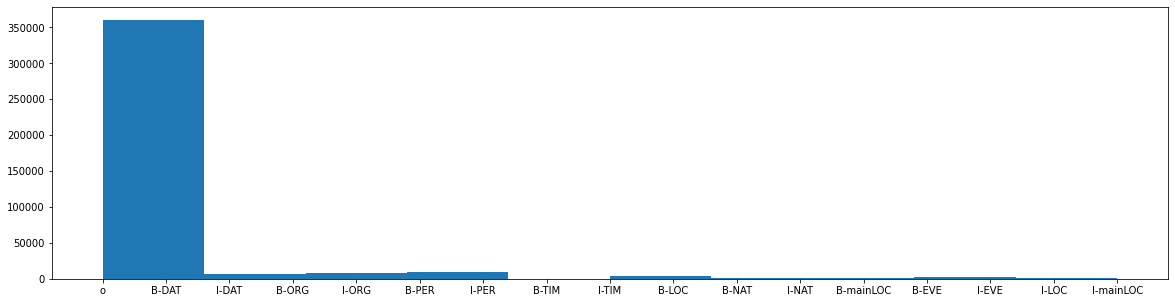

In [11]:
import matplotlib.pyplot as plt
labels_dist = []
for item in data_train['labels']:
    labels_dist = labels_dist + item

plt.figure(figsize=(20,5))
plt.hist(labels_dist, )

In [12]:
labels, counts=np.unique(np.array(labels_dist),return_counts=True)
label_counts = {}
for label, count in zip(labels,counts):
    label_counts[label] = count
label_counts

{'B-DAT': 1434,
 'B-EVE': 772,
 'B-LOC': 2965,
 'B-NAT': 598,
 'B-ORG': 4622,
 'B-PER': 4318,
 'B-TIM': 231,
 'B-mainLOC': 469,
 'I-DAT': 1868,
 'I-EVE': 1692,
 'I-LOC': 1464,
 'I-NAT': 150,
 'I-ORG': 7499,
 'I-PER': 5070,
 'I-TIM': 275,
 'I-mainLOC': 275,
 'o': 359011}

In [13]:

from datasets import Dataset
dataset_train = Dataset.from_pandas(data_train)
dataset_val = Dataset.from_pandas(data_val)
dataset_test = Dataset.from_pandas(data_test)

### new Way

In [14]:
labels = ["B-DAT", "B-TIM", "B-PER", "B-ORG", "B-LOC", "B-EVE", "B-NAT", "B-mainLOC", "I-DAT", "I-TIM", "I-PER", "I-ORG", "I-LOC", "I-EVE", "I-NAT", "I-mainLOC", "o"]
id2label = {}
label2id = {}
for i, item in enumerate(labels):
    id2label[i] = item
    label2id[item] = i
id2label

{0: 'B-DAT',
 1: 'B-TIM',
 2: 'B-PER',
 3: 'B-ORG',
 4: 'B-LOC',
 5: 'B-EVE',
 6: 'B-NAT',
 7: 'B-mainLOC',
 8: 'I-DAT',
 9: 'I-TIM',
 10: 'I-PER',
 11: 'I-ORG',
 12: 'I-LOC',
 13: 'I-EVE',
 14: 'I-NAT',
 15: 'I-mainLOC',
 16: 'o'}

In [15]:
batch_size = 256
task = "ner" 
model_name = 'HooshvareLab/bert-fa-zwnj-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [55]:
def tokenize_and_align_labels(examples):
    label_all_tokens = True
    tokenized_inputs = tokenizer(list(examples["token"]), padding="max_length",max_length= 128, truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(16)
            elif label[word_idx] == '0':
                label_ids.append(0)
            elif word_idx != previous_word_idx:
                label_ids.append(label2id[label[word_idx]])
            else:
                label_ids.append(label2id[label[word_idx]] if label_all_tokens else 16)
            previous_word_idx = word_idx
        labels.append(label_ids)
    
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [56]:
dataset_test_tokenized=dataset_test.map(tokenize_and_align_labels,batched=True)
dataset_val_tokenized = dataset_val.map(tokenize_and_align_labels,batched=True)
dataset_train_tokenized = dataset_train.map(tokenize_and_align_labels,batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [33]:
#dataset_test_tokenized.remove_columns("token")
#dataset_val_tokenized.remove_columns("token")
#dataset_train_tokenized.remove_columns("token")

(array([   0.,    0.,    0.,    0.,    0., 4050.,    0.,    0.,    0.,
           0.]),
 array([127.5, 127.6, 127.7, 127.8, 127.9, 128. , 128.1, 128.2, 128.3,
        128.4, 128.5]),
 <a list of 10 Patch objects>)

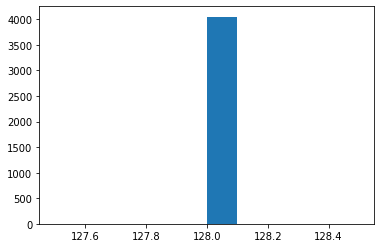

In [34]:
plt.hist([len(item) for item in iter(dataset_train_tokenized['attention_mask'])])

In [35]:
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(id2label))
model.config.id2label = id2label
model.config.label2id = label2id
model.config._num_labels = len(id2label)
model.config.num_labels = len(label2id)
model

Some weights of the model checkpoint at HooshvareLab/bert-fa-zwnj-base were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-zwnj-

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(42000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [48]:
# you should freeze all parameters except classifier
# otherwise, you will be training the BERT!!
for param in model.bert.parameters():
    param.requires_grad = False

args = TrainingArguments(
    f"test-{task}",
    evaluation_strategy = "epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=1e-5,
)

In [49]:
data_collator = DataCollatorForTokenClassification(tokenizer)
metric = load_metric("seqeval")

In [50]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [[labels[p] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]
    true_labels = [[labels[l] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {"precision": results["overall_precision"], "recall": results["overall_recall"], "f1": results["overall_f1"], "accuracy": results["overall_accuracy"]}
    

In [39]:
dataset_train_tokenized

Dataset({
    features: ['token', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4050
})

In [51]:
class NERDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.labels = torch.tensor(dataset['labels'])
        self.input_ids = torch.tensor(dataset['input_ids'])
        self.token_type_ids = torch.tensor(dataset['token_type_ids'])
        self.attention_mask = torch.tensor(dataset['attention_mask'])


    def __getitem__(self, idx):
        item = {'labels': self.labels[idx], 
                'input_ids': self.input_ids[idx],
                'token_type_ids': self.token_type_ids[idx],
                'attention_mask': self.attention_mask[idx]}
        return item

    def __len__(self):
        return len(self.labels)

In [57]:
train_dataset = NERDataset(dataset_train_tokenized)
val_dataset = NERDataset(dataset_val_tokenized)
test_dataset = NERDataset(dataset_test_tokenized)

In [42]:
!pip install -Uqq pytorch_lightning

In [72]:
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchmetrics
import torch
import torchmetrics.functional as TF
from torchmetrics import ConfusionMatrix

# important
from torch.utils.data import WeightedRandomSampler

class LiteModel(pl.LightningModule):
    def __init__(self,model, train_dataset, val_dataset, test_dataset, batch_size,num_classes):
        super(LiteModel, self).__init__()
        self.model = model
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size
        self.num_classes = num_classes

        self.train_acc = torchmetrics.Accuracy()
        self.train_f1 = torchmetrics.F1Score(num_classes=num_classes,mdmc_reduce='global')
        self.train_auroc = torchmetrics.AUROC(num_classes=num_classes,mdmc_reduce='global')

        self.val_acc = torchmetrics.Accuracy()
        self.val_f1 = torchmetrics.F1Score(num_classes=num_classes)
        self.val_auroc = torchmetrics.AUROC(num_classes=num_classes)
        
        self.test_acc = torchmetrics.Accuracy()
        self.test_f1= torchmetrics.F1Score(num_classes=num_classes)
        self.test_auroc = torchmetrics.AUROC(num_classes=num_classes)

        self.confusion_matrix = ConfusionMatrix(num_classes=num_classes)


    def forward(self, x):
        return model(**x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=2,verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': lr_scheduler,
            'monitor': 'val_loss'
        }

    def training_step(self, batch, batch_idx):
        output= self(batch)

        softmax = output.logits.softmax(dim=1)
        y_pred = torch.argmax(softmax, dim=1)
        y_target = batch['labels'][:,0:y_pred.shape[1]]

        acc = self.train_acc(y_pred, y_target)
        f1 = self.train_f1(y_pred, y_target)
        self.train_auroc.update(softmax, y_target)

        self.log("train_loss", output.loss,prog_bar=True)
        self.log("train_accuracy", acc,prog_bar=True)
        self.log("train_f1", f1,prog_bar=True)

        return {'loss': output.loss}

    def validation_step(self, batch, batch_idx):
        output = self(batch)        

        softmax = output.logits.softmax(dim=1)
        y_pred = torch.argmax(softmax, dim=1)
        y_target = batch['labels'][:,0:y_pred.shape[1]]
        self.val_acc.update(y_pred, y_target)
        self.val_f1.update(y_pred, y_target)
        self.val_auroc.update(softmax, y_target)

        return output.loss

    def test_step(self, batch, batch_idx):
        output = self(batch)        

        softmax = output.logits.softmax(dim=1)
        y_pred = torch.argmax(softmax, dim=1)
       
        y_target = batch['labels'][:,0:y_pred.shape[1]]

        self.test_acc.update(y_pred, y_target)
        self.test_f1.update(y_pred, y_target)
        self.test_auroc.update(softmax, y_target)

        matrix=self.confusion_matrix(y_pred, y_target)

        return {'loss': output.loss,
                'confusion_matrix': matrix }

    def training_epoch_end(self, training_step_outputs):
        train_loss = torch.tensor([item['loss'] for item in training_step_outputs]).mean()
        train_accuracy = self.train_acc.compute()
        train_f1 = self.train_f1.compute()
        train_auroc = self.train_auroc.compute()

        self.log("epoch_train_accuracy", train_accuracy)
        self.log("epoch_train_f1", train_f1)

        self.train_acc.reset()
        self.train_f1.reset()
        self.train_auroc.reset()
        print(f"\ntraining accuracy: {train_accuracy:.4}, "\
        f"f1: {train_f1:.4}, auroc: {train_auroc:.4}")

    def validation_epoch_end(self, validation_step_outputs):
        val_loss = torch.tensor(validation_step_outputs).mean()
        val_accuracy = self.val_acc.compute()
        val_f1 = self.val_f1.compute()
        val_auroc = self.val_auroc.compute()
        
        self.log("val_accuracy", val_accuracy)
        self.log("val_loss", val_loss)
        self.log("val_f1", val_f1)
        self.log("val_auroc", val_auroc)
       
        self.val_acc.reset()
        self.val_f1.reset()
        self.val_auroc.reset()
        print(f"\nvalidation accuracy: {val_accuracy:.4} "\
        f"f1: {val_f1:.4}, auroc: {val_auroc:.4}")

        return {'val_loss': val_loss}
    
    def test_epoch_end(self, outputs) -> None:
        loss = [item['loss'] for item in outputs]

        test_loss = torch.tensor(loss).mean()
        test_accuracy = self.test_acc.compute()
        test_f1 = self.test_f1.compute()
        test_auroc = self.test_auroc.compute()
        
        self.log("test_accuracy", test_accuracy)
        self.log("test_loss", test_loss)
        self.log("test_f1", test_f1)
        self.log("test_auroc", test_auroc)
       
        self.test_acc.reset()
        self.test_f1.reset()
        self.test_auroc.reset()
        print(f"\ntest accuracy: {test_accuracy:.4} "\
        f"f1: {test_f1:.4}, auroc: {test_auroc:.4}")

        final_confusion_matrix = torch.zeros(self.num_classes, self.num_classes,device=self.device)    
        for item in outputs:
            final_confusion_matrix += item['confusion_matrix']
        
        self.final_matrix = final_confusion_matrix

    def train_dataloader(self)-> DataLoader:
        return DataLoader(dataset= self.train_dataset, 
                          batch_size=self.batch_size)
        len_dataset = len(self.train_dataset)
        bincount=torch.tensor(self.train_dataset.labels).bincount()
        dataset_weight=bincount/len_dataset
        sampler_weight = 1/dataset_weight
        weights = [sampler_weight[label].item() for label in self.train_dataset.labels]
        sampler=WeightedRandomSampler(weights,num_samples=len_dataset)
        return DataLoader(dataset = self.train_dataset,
                          batch_size = self.batch_size,
                          sampler=sampler)

    def val_dataloader(self) -> DataLoader:
        return DataLoader(dataset = self.val_dataset,
                          batch_size=self.batch_size)

    def test_dataloader(self) -> DataLoader:
        return DataLoader(dataset= self.test_dataset,
                          batch_size=self.batch_size)

In [73]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

BATCH_SIZE = 32
NUM_CLASSES= len(id2label)
net = LiteModel(model, train_dataset, val_dataset, test_dataset, BATCH_SIZE,NUM_CLASSES)

checkpoint_callback = ModelCheckpoint(dirpath='/content/models')


trainer = Trainer(accelerator='auto',
                  devices='auto',
                  max_epochs=10,
                  overfit_batches=1,
                  log_every_n_steps=1,
                  callbacks=[checkpoint_callback])


#trainer = Trainer(
#   net,
#    args,
#    train_dataset=train_dataloader,
#    eval_dataset= dataset_val_tokenized,
#    data_collator=data_collator,
#    tokenizer=tokenizer,
#    compute_metrics=compute_metrics
#)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.


In [74]:
trainer.fit(model=net)

Missing logger folder: /content/lightning_logs

   | Name             | Type                       | Params
-----------------------------------------------------------------
0  | model            | BertForTokenClassification | 117 M 
1  | train_acc        | Accuracy                   | 0     
2  | train_f1         | F1Score                    | 0     
3  | train_auroc      | AUROC                      | 0     
4  | val_acc          | Accuracy                   | 0     
5  | val_f1           | F1Score                    | 0     
6  | val_auroc        | AUROC                      | 0     
7  | test_acc         | Accuracy                   | 0     
8  | test_f1          | F1Score                    | 0     
9  | test_auroc       | AUROC                      | 0     
10 | confusion_matrix | ConfusionMatrix            | 0     
-----------------------------------------------------------------
13.1 K    Trainable params
117 M     Non-trainable params
117 M     Total params
470.879   Total est

Training: 0it [00:00, ?it/s]

ValueError: ignored

In [ ]:
#trainer.evaluate()

In [ ]:
trainer.save_model('un-ner.model')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('./un-ner.model/')

In [ ]:
import torch
paragraph = '''مدیرکل محیط سازمان زیست استان البرز با بیان اینکه با بیان اینکه موضوع شیرها به های زباله های انتقال یافته در منطقه موقعیت حلقه موقعیت دره موقعیت خطری برای این استان است ، گفت : در این مورد گزارشاتی در ۲۵تاریخ مردادتاریخ ۱۳۹۷تاریخ تقدیم مدیران استان شده است .'''
tokens = tokenizer(paragraph)
torch.tensor(tokens['input_ids']).unsqueeze(0).size()

In [ ]:
model = AutoModelForTokenClassification.from_pretrained('./un-ner.model/')
predictions = model.forward(input_ids=torch.tensor(tokens['input_ids']).unsqueeze(0), attention_mask=torch.tensor(tokens['attention_mask']).unsqueeze(0))
predictions = torch.argmax(predictions.logits.squeeze(), axis=1)
predictions = [labels[i] for i in predictions]

In [ ]:
words = tokenizer.batch_decode(tokens['input_ids'])
pd.DataFrame({'ner': predictions, 'words': words}).to_csv('un_ner.csv')

In [ ]:
answers = pd.read_csv('./un_ner.csv')
answers